In [3]:
import os
import re
import cv2
import nltk
import json
import random
import numpy as np
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
from collections import defaultdict
from nltk.corpus import stopwords

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.models.efficientnet import EfficientNet_B0_Weights
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [4]:
# //TODO::WTF::

IMAGES_DIR = "/kaggle/input/flickr8k/Images"
CAPTIONS_FILE = "/kaggle/input/flickr8k/captions.txt"

BATCH_SIZE = 32

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
def load_captions(captions_file):
    captions_dict = {}
    with open(captions_file, 'r') as file:
        for line in file:
            tokens = line.strip().split(",") 
            if len(tokens) == 2:
                image_id, caption = tokens
                if image_id not in captions_dict:
                    captions_dict[image_id] = []
                captions_dict[image_id].append(caption)
    return captions_dict

def display_images_with_captions(images_dir, captions_dict, num_images=3, image_size=(224, 224)):
    images = list(captions_dict.keys())
    if len(images) < num_images: raise ValueError(f"Doesn't Exist.")    
    selected_images = random.sample(images, num_images)
    plt.figure(figsize=(10 * num_images, 10))
    for i, image in enumerate(selected_images):
        img_path = os.path.join(images_dir, image)
        img = Image.open(img_path)        
        plt.subplot(num_images, 1, i + 1)
        plt.imshow(img)
        plt.axis('off')
        captions = "\n".join(captions_dict[image]) 
        plt.title(captions, fontsize=10, loc='center', wrap=True)
    plt.tight_layout()
    plt.show()

def plot_training_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o', label='Training Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, marker='x', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.grid(True)
    plt.legend()
    plt.show()

# def display_random_images_with_captions(images_dir, captions_dict, num_images=5):
#     selected_images = random.sample(list(captions_dict.keys()), num_images)
#     plt.figure(figsize=(15, 10))

#     for i, image_id in enumerate(selected_images):
#         img_path = f"{images_dir}/{image_id}"
#         img = Image.open(img_path)

#         plt.subplot(num_images, 1, i + 1)
#         # plt.subplot(1, num_images, i + 1)
#         plt.imshow(img)
#         plt.axis("off")
#         plt.title(captions_dict[image_id], fontsize=10)
    
#     plt.tight_layout()
#     plt.show()
        
def plot_caption_length_variation(captions_dict):
    lengths = []
    for captions in captions_dict.values():
        lengths.extend([len(caption.split()) for caption in captions])
    plt.figure(figsize=(15, 10))
    plt.scatter(range(len(lengths)), lengths, alpha=0.5)
    plt.title("Variation in Caption Lengths", fontsize=14)
    plt.xlabel("Caption Index", fontsize=12)
    plt.ylabel("Caption Length (Number of Words)", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.show()

def plot_word_frequency_histogram(captions_dict, top_n=20):
    word_counter = Counter()
    for captions in captions_dict.values():
        for caption in captions:
            preprocessed_caption = preprocess_text(caption)
            word_counter.update(preprocessed_caption.split())
    most_common_words = word_counter.most_common(top_n)
    words, counts = zip(*most_common_words)
    plt.figure(figsize=(12, 6))
    plt.bar(words, counts, color='skyblue')
    plt.title(f"Top {top_n} Most Frequent Words", fontsize=14)
    plt.xlabel("Words", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.xticks(rotation=45, fontsize=10)
    plt.tight_layout()
    plt.show()

In [6]:
def split_dataset(captions_dict, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1, random_seed=42):
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6, "Ratios must sum to 1."

    flattened_captions = []
    for image_id, captions in captions_dict.items():
        for caption in captions:
            flattened_captions.append((image_id, caption))

    random.seed(random_seed)
    random.shuffle(flattened_captions)

    total_samples = len(flattened_captions)
    train_end = int(total_samples * train_ratio)
    val_end = train_end + int(total_samples * val_ratio)

    train_samples = flattened_captions[:train_end]
    val_samples = flattened_captions[train_end:val_end]
    test_samples = flattened_captions[val_end:]

    train_captions = {image_id: [] for image_id, _ in train_samples}
    for image_id, caption in train_samples:
        train_captions[image_id].append(caption)

    val_captions = {image_id: [] for image_id, _ in val_samples}
    for image_id, caption in val_samples:
        val_captions[image_id].append(caption)

    test_captions = {image_id: [] for image_id, _ in test_samples}
    for image_id, caption in test_samples:
        test_captions[image_id].append(caption)

    return train_captions, val_captions, test_captions

def save_captions_to_json(captions, filepath):
    with open(filepath, 'w') as file:
        json.dump(captions, file, ensure_ascii=False, indent=4)

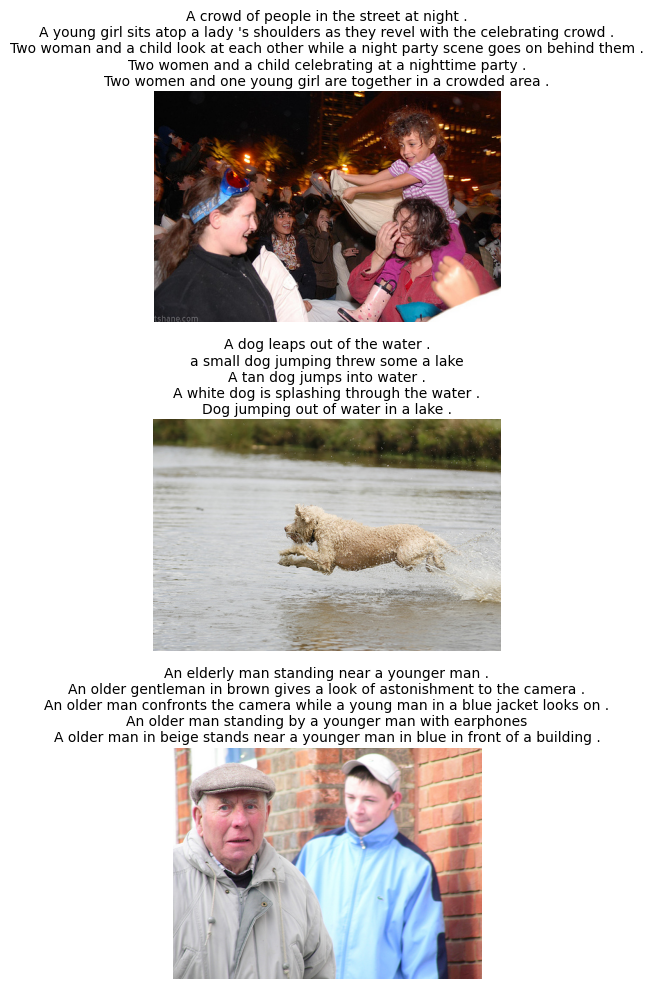

In [7]:
captions_dict = load_captions(CAPTIONS_FILE)
display_images_with_captions(IMAGES_DIR, captions_dict)

In [8]:
import nltk
from collections import defaultdict
import re
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"[^\w\s]", "", text)  # Remove punctuation
    text = re.sub(r"\d+", "", text)      # Remove numbers
    words = text.split()                 # Tokenize text
    words = [word for word in words if word not in stop_words]  # Remove stop words
    return " ".join(words).strip()

token_to_index = {"<pad>": 0, "<sos>": 1, "<eos>": 2, "<unk>": 3}

index_to_word = {v: k for k, v in token_to_index.items()}  # Reverse the token_to_index mapping

vocab = set()
all_words_dict = {}

for captions in captions_dict.values():
    for caption in captions:
        preprocessed_caption = preprocess_text(caption)
        for word in preprocessed_caption.split():
            if word not in token_to_index:  
                idx = len(token_to_index)
                token_to_index[word] = idx
                index_to_word[idx] = word
                vocab.add(word)
            
            if word not in all_words_dict:
                all_words_dict[word] = len(all_words_dict)

word_to_index_dictionary = dict(token_to_index)
index_to_word_dictionary = dict(index_to_word)

print("Word to Index:", len(word_to_index_dictionary))
print("Index to Word:", len(index_to_word_dictionary))
print("All Words Dictionary:", len(all_words_dict))  # Output the size of the all_words_dict

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Word to Index: 8366
Index to Word: 8366
All Words Dictionary: 8362


In [9]:
TOKENIZER_FILE = "tokenizer.json"
with open(TOKENIZER_FILE, 'w') as file:
    json.dump(word_to_index_dictionary, file, ensure_ascii=False, indent=4)
print(f"Word to Index Tokenizer saved to {TOKENIZER_FILE}. Total tokens: {len(word_to_index_dictionary)}")

# with open(TOKENIZER_FILE, "r") as file:
#     word_to_index_dictionary = json.load(file)

Word to Index Tokenizer saved to tokenizer.json. Total tokens: 8366


In [10]:
train_captions, val_captions, test_captions = split_dataset(captions_dict)

save_captions_to_json(train_captions, "train_captions.json")
save_captions_to_json(val_captions, "val_captions.json")
save_captions_to_json(test_captions, "test_captions.json")

print("Dataset split complete:")
print(f"Training: {len(train_captions)} images")
print(f"Validation: {len(val_captions)} images")
print(f"Test: {len(test_captions)} images")

Dataset split complete:
Training: 8084 images
Validation: 3166 images
Test: 3119 images


In [11]:
class FlickrDataset(Dataset):
    def __init__(self, captions_file, images_dir, transform=None, tokenizer=None, max_seq_length=50):
        with open(captions_file, 'r') as file:
            self.captions_dict = json.load(file)
        self.images_dir = images_dir
        self.transform = transform
        self.tokenizer = tokenizer
        self.max_seq_length = max_seq_length
        self.image_caption_pairs = []
        for image_id, captions in self.captions_dict.items():
            image_path = os.path.join(images_dir, image_id)
            if not os.path.exists(image_path): continue
            for caption in captions:
                self.image_caption_pairs.append((image_id, caption))
        random.shuffle(self.image_caption_pairs)
    
    def __len__(self):
        return len(self.image_caption_pairs)

    def __getitem__(self, idx):
        image_id, caption = self.image_caption_pairs[idx]
        image_path = os.path.join(self.images_dir, image_id)
        image = Image.open(image_path).convert("RGB")
        if self.transform: image = self.transform(image)
        if self.tokenizer: caption = self.tokenizer(caption)
        return image, caption

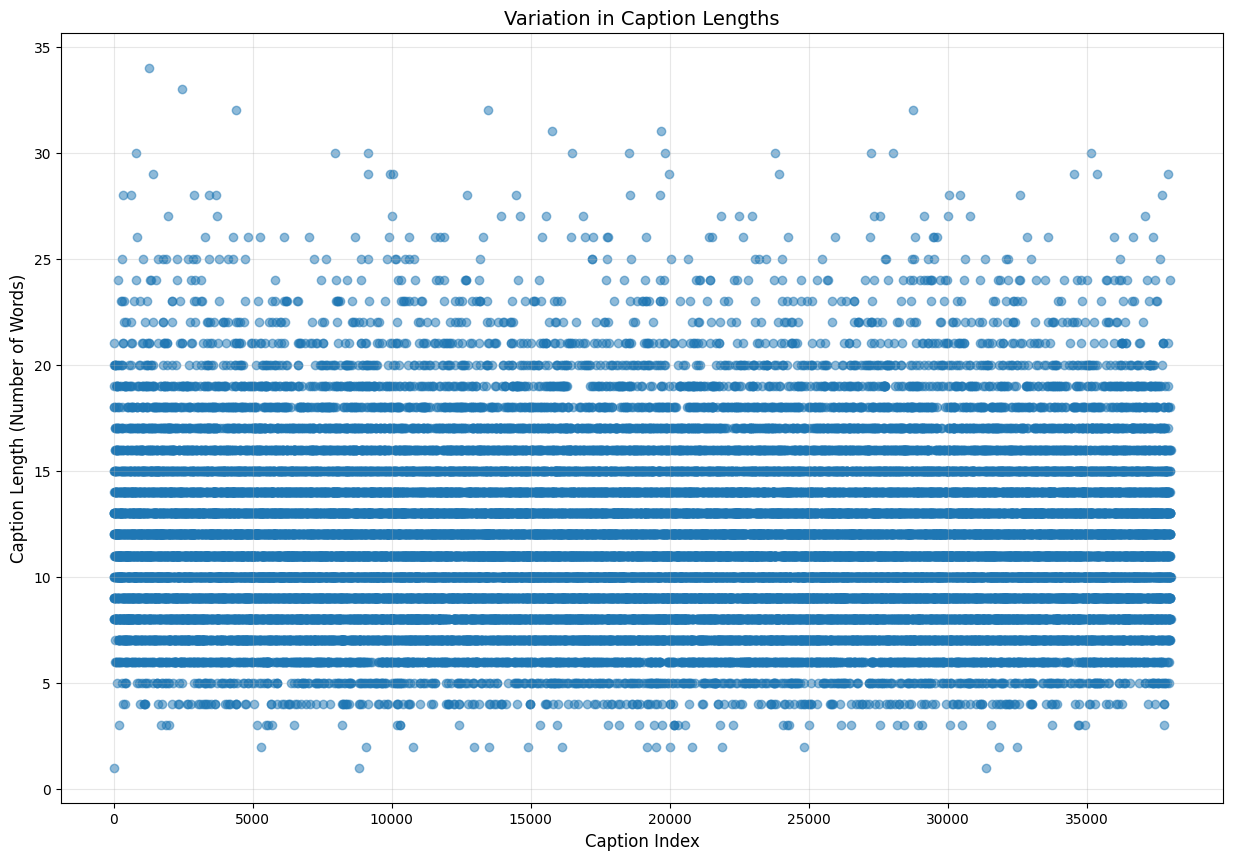

In [12]:
plot_caption_length_variation(captions_dict)

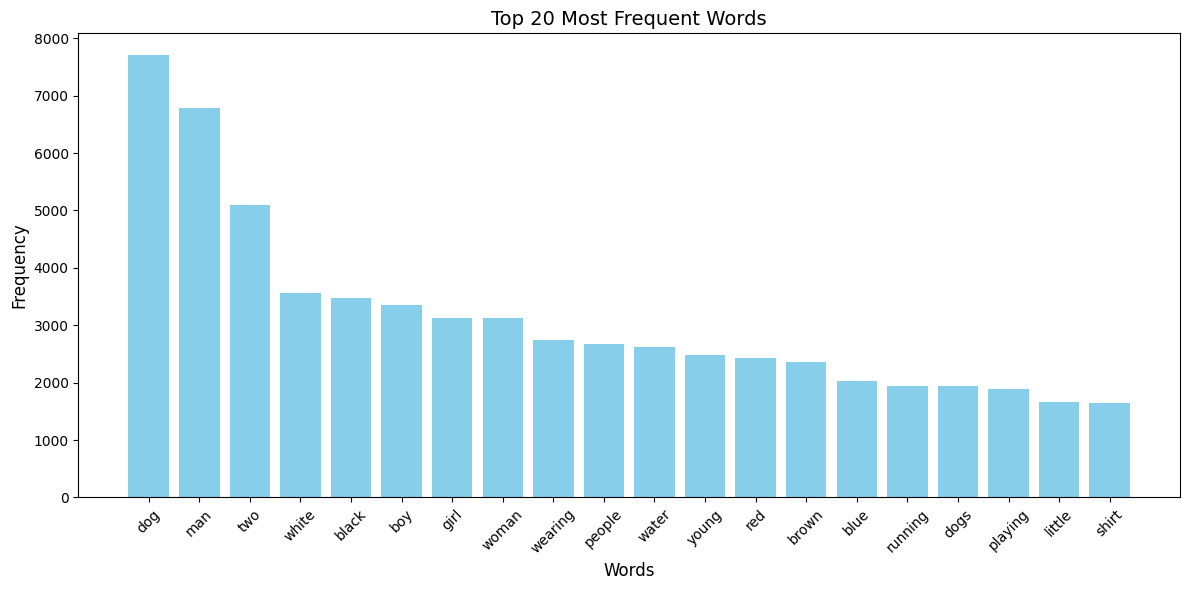

In [13]:
plot_word_frequency_histogram(captions_dict, top_n=20)

In [14]:
def pad_caption(caption, word_to_index, max_length=15):
    tokens = ["<sos>"] + caption.lower().split() + ["<eos>"]
    token_ids = [word_to_index.get(word, word_to_index["<unk>"]) for word in tokens]
    if len(token_ids) < max_length:
        token_ids += [word_to_index["<pad>"]] * (max_length - len(token_ids))
    else:
        token_ids = token_ids[:max_length]  # Truncate if too long
    return torch.tensor(token_ids)

PAD_IDX = word_to_index_dictionary["<pad>"]

In [15]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

denormalize = transforms.Compose([
    transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225], 
                         std=[1/0.229, 1/0.224, 1/0.225])
])

train_dataset = FlickrDataset("train_captions.json", IMAGES_DIR, transform=transform, tokenizer=lambda caption: pad_caption(caption, word_to_index_dictionary))
val_dataset = FlickrDataset("val_captions.json", IMAGES_DIR, transform=val_transform, tokenizer=lambda caption: pad_caption(caption, word_to_index_dictionary))
test_dataset = FlickrDataset("test_captions.json", IMAGES_DIR, transform=val_transform, tokenizer=lambda caption: pad_caption(caption, word_to_index_dictionary))

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Testing batches: {len(test_loader)}")

Training batches: 951
Validation batches: 119
Testing batches: 119


In [16]:
# class VGG16Encoder(nn.Module):
#     def __init__(self, embed_size):
#         super(VGG16Encoder, self).__init__()
#         vgg16 = models.vgg16(pretrained=True)
#         modules = list(vgg16.features.children())  # Extract feature layers
#         self.vgg16 = nn.Sequential(*modules)
#         self.fc = nn.Linear(512 * 7 * 7, embed_size)
#         self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
    
#     def forward(self, images):
#         features = self.vgg16(images)
#         features = features.view(features.size(0), -1)
#         features = self.fc(features)
#         features = self.bn(features)
#         return features

# class LSTMDecoder(nn.Module):
#     def __init__(self, embed_size, hidden_size, vocab_size, num_layers, dropout=0.5):
#         super(LSTMDecoder, self).__init__()
#         self.embed = nn.Embedding(vocab_size, embed_size)
#         self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
#         self.fc = nn.Linear(hidden_size, vocab_size)
#         self.dropout = nn.Dropout(dropout)
    
#     def forward(self, features, captions):
#         embeddings = self.embed(captions)
#         embeddings = torch.cat((features.unsqueeze(1), embeddings), dim=1)
#         hiddens, _ = self.lstm(embeddings)
#         outputs = self.fc(hiddens)
#         return outputs
    
#     def generate_caption(self, features, tokenizer, max_length=20):
#         vocab_size = len(tokenizer)
#         index_to_word = {idx: word for word, idx in tokenizer.items()}
#         start_token, end_token = tokenizer['<sos>'], tokenizer['<eos>']
#         caption = [start_token]
#         hidden = None
        
#         for _ in range(max_length):
#             input_word = torch.tensor([caption[-1]], device=features.device).unsqueeze(0)
#             embedded = self.embed(input_word)
#             if hidden is None:
#                 lstm_out, hidden = self.lstm(embedded, None)
#             else:
#                 lstm_out, hidden = self.lstm(embedded, hidden)
#             output = self.fc(lstm_out.squeeze(1))
#             predicted = output.argmax(dim=1).item()
#             caption.append(predicted)
#             if predicted == end_token:
#                 break
        
#         return ' '.join(index_to_word[idx] for idx in caption if idx not in {start_token, end_token})

class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        self.model = models.efficientnet_b0(pretrained=True)
        self.model.classifier = nn.Identity()
        self.fc = nn.Linear(1280, embed_size)
        self.relu = nn.ReLU()
        self.first_call = True
    
    def forward(self, images):
        features = self.model(images)
        features = self.fc(features)
        features = self.relu(features)
        if self.first_call:
            print(f"[INFO] Encoder output shape: {features.shape}")
            self.first_call = False
        return features

class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        super(DecoderRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)
        self.softmax = nn.LogSoftmax(dim=2)
        self.first_call = True
    
    def forward(self, features, captions):
        embeddings = self.embedding(captions)
        inputs = torch.cat((features.unsqueeze(1), embeddings), dim=1)
        outputs, _ = self.lstm(inputs)
        outputs = self.fc(outputs)
        if self.first_call:
            print(f"[INFO] Decoder output shape: {outputs.shape}")
            self.first_call = False
        return self.softmax(outputs)

class ImageCaptioningModel(nn.Module):
    def __init__(self, vocab_size, embed_size=512, hidden_size=512, num_layers=1, dropout=0.5):
        super(ImageCaptioningModel, self).__init__()
        self.encoder = EncoderCNN(embed_size).to(device)
        self.decoder = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers).to(device) # , dropout

    def forward(self, images, captions):
        features = self.encoder(images)  # Extract image features
        outputs = self.decoder(features, captions)  # Generate captions
        return outputs

In [17]:
# def masked_cross_entropy_loss(outputs, targets):
#     loss_fn = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
#     return loss_fn(outputs.permute(0, 2, 1), targets)  # Permute for [batch_size, vocab_size, seq_len]

# def masked_cross_entropy_loss(predictions, targets, pad_token=0):
#     batch_size, seq_len, vocab_size = predictions.shape
#     predictions = predictions.view(-1, vocab_size)  # Flatten logits to (batch_size * seq_len, vocab_size)
#     targets = targets.view(-1)  # Flatten targets to (batch_size * seq_len)
#     mask = targets != pad_token
#     loss = F.cross_entropy(predictions, targets, reduction='none')
#     loss = loss * mask
#     return loss.sum() / mask.sum()

def masked_cross_entropy_loss(predictions, targets, pad_token=0):
    batch_size, seq_len, vocab_size = predictions.shape
    predictions = predictions.reshape(-1, vocab_size)  # Flatten logits
    targets = targets.reshape(-1)  # Flatten targets
    mask = targets != pad_token
    loss_fn = nn.CrossEntropyLoss(ignore_index=pad_token, label_smoothing=0.1) # F.cross_entropy
    loss = loss_fn(predictions, targets) # , reduction='none'
    loss = loss * mask
    return loss.sum() / mask.sum()

def save_checkpoint(model, optimizer, epoch, loss, checkpoint_path="checkpoint.pth"):
    checkpoint = {
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "epoch": epoch,
        "loss": loss,
    }
    torch.save(checkpoint, checkpoint_path)

def load_checkpoint(checkpoint_path, model, optimizer): # //TODO::WTF:: I don't know how to use till no.
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    epoch = checkpoint["epoch"]
    loss = checkpoint["loss"]
    print(f"Checkpoint loaded from epoch {epoch}")
    return epoch, loss

def generate_caption(model, image, tokenizer, max_length=20):
    model.eval() 

    index_to_word = {index: word for word, index in tokenizer.items()}
    start_token = tokenizer["<sos>"]
    end_token = tokenizer["<eos>"]

    with torch.no_grad():
        features = model.encoder(image.unsqueeze(0).to(device))

        caption = [start_token]  # Begin with <sos>
        for _ in range(max_length):
            caption_tensor = torch.tensor([caption], device=device)  # Shape: (1, current_seq_len)
            outputs = model.decoder(features, caption_tensor)
            next_word_idx = outputs[0, -1].argmax().item()
            caption.append(next_word_idx)
            if next_word_idx == end_token:
                break

    words = [index_to_word[idx] for idx in caption if idx != start_token and idx != end_token]
    return " ".join(words)

# def visualize_results(model, dataloader, tokenizer, num_images=5):
#     model.eval()
#     for images, _ in dataloader:
#         images = images[:num_images].to(device)
#         denorm_images = torch.stack([denormalize(img) for img in images])
#         captions = [generate_caption(model, image, tokenizer) for image in images]
#         plt.figure(figsize=(5, num_images * 5))
#         for i in range(num_images):
#             ax = plt.subplot(num_images, 1, i + 1)
#             img = denorm_images[i].permute(1, 2, 0).cpu().numpy()
#             img = img.clip(0, 1)  # Ensure pixel values are in [0,1] range
#             ax.imshow(img)
#             ax.axis("off")  # Remove axes
#             ax.set_title(captions[i], fontsize=12, wrap=True)
#         plt.tight_layout()
#         plt.show()
#         break

In [18]:
!pip install rouge-score

In [19]:
from rouge_score import rouge_scorer  # Add this import
import torch
import matplotlib.pyplot as plt
import random
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

def compute_rouge_scores(references, hypotheses):
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    rouge_l_scores = [scorer.score(" ".join(refs[0]), " ".join(hyp))['rougeL'].fmeasure for refs, hyp in zip(references, hypotheses)]
    return np.mean(rouge_l_scores)

def compute_bleu_scores(references, hypotheses):
    smoothie = SmoothingFunction().method1
    bleu1 = corpus_bleu(references, hypotheses, weights=(1.0, 0, 0, 0), smoothing_function=smoothie)
    bleu2 = corpus_bleu(references, hypotheses, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothie)
    bleu3 = corpus_bleu(references, hypotheses, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothie)
    bleu4 = corpus_bleu(references, hypotheses, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothie)
    return bleu1, bleu2, bleu3, bleu4


def evaluate_model(model, data_loader, tokenizer, num_samples=5):
    model.eval()
    references = []
    hypotheses = []
    images_samples = []
    index_to_word = {index: word for word, index in tokenizer.items()}

    with torch.no_grad():
        for images, captions in data_loader:
            images = images.to(device)
            captions = captions.to(device)
            predicted_captions = [generate_caption(model, image, tokenizer) for image in images]
            true_captions = []
            for caption in captions.cpu().numpy():
                words = [index_to_word[idx] for idx in caption if idx not in {tokenizer["<sos>"], tokenizer["<eos>"], tokenizer["<pad>"]}]
                true_captions.append(" ".join(words))
            references.extend([[ref] for ref in true_captions])  # BLEU expects list of list format
            hypotheses.extend(predicted_captions)
            images_samples.extend(images.cpu())

    bleu1, bleu2, bleu3, bleu4 = compute_bleu_scores(references, hypotheses)
    rouge_l = compute_rouge_scores(references, hypotheses)

    print(f"\n[INFO] Evaluation on test set:")
    print(f"BLEU-1 Score: {bleu1:.4f}")
    print(f"BLEU-2 Score: {bleu2:.4f}")
    print(f"BLEU-3 Score: {bleu3:.4f}")
    print(f"BLEU-4 Score: {bleu4:.4f}")
    print(f"ROUGE-L Score: {rouge_l:.4f}")

    selected_indices = random.sample(range(len(images_samples)), min(num_samples, len(images_samples)))    
    fig, axes = plt.subplots(len(selected_indices), 1, figsize=(8, len(selected_indices) * 3))
    if len(selected_indices) == 1: axes = [axes]
    for i, idx in enumerate(selected_indices):
        img = images_samples[idx].permute(1, 2, 0).numpy()
        img = (img - img.min()) / (img.max() - img.min())  # Normalize image for display
        ref_caption = references[idx][0]
        hyp_caption = hypotheses[idx]
        axes[i].imshow(img)
        axes[i].axis("off")
        axes[i].set_title(f"Real: {ref_caption}\nPred: {hyp_caption}", fontsize=10)
    plt.tight_layout()
    plt.show()

In [20]:
def train_model(
    model, train_loader, val_loader, optimizer, num_epochs=50, 
    checkpoint_path="checkpoint.pth", resume=False, patience=5,
    weight_decay=1e-4
):
    model.train()
    if resume and os.path.exists(checkpoint_path):
        start_epoch, _ = load_checkpoint(checkpoint_path, model, optimizer)
    else:
        start_epoch = 0
        
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0 

    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.5)
    for epoch in range(start_epoch, num_epochs):
        model.train()
        epoch_loss = 0
        tepoch = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
        for batch_idx, (images, captions) in enumerate(tepoch):
            images, captions = images.to(device), captions.to(device)
            optimizer.zero_grad()

            outputs = model(images, captions[:, :-1])  # Exclude the last word for teacher forcing            
            outputs = outputs[:, :captions.size(1) - 1, :]  # Match target sequence length

            loss = masked_cross_entropy_loss(outputs, captions[:, 1:])  # Exclude <sos> for target TODO::WTF:: what about the first character? it should be excluded too.
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            tepoch.set_postfix(loss=f"{loss.item():.4f}")

        train_losses.append(epoch_loss / len(train_loader))
        print(f"Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}")

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, captions in val_loader:
                images, captions = images.to(device), captions.to(device)
                outputs = model(images, captions[:, :-1])
                outputs = outputs[:, :captions.size(1) - 1, :]
                loss = masked_cross_entropy_loss(outputs, captions[:, 1:])
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        print(f"Epoch {epoch+1}, Validation Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0 
            save_checkpoint(model, optimizer, epoch + 1, val_loss, checkpoint_path)
        elif val_loss >= best_val_loss:
            patience_counter += 1
            print(f"No improvement in validation loss for {patience_counter} epoch(s).")

        if patience_counter == 8:
            scheduler.step()
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

    return train_losses, val_losses

In [21]:
vocab_size = len(word_to_index_dictionary)
learning_rate = 0.001
weight_decay = 1e-4

model = ImageCaptioningModel(
    vocab_size, embed_size=256, hidden_size=512, num_layers=1, dropout=0.5
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [22]:
# print(model)

In [23]:
train_losses, val_losses = train_model(
    model, train_loader, val_loader, optimizer, num_epochs=15, 
    checkpoint_path="caption_model.pth", patience=15
)

Epoch 1/15:   0%|          | 0/951 [00:00<?, ?it/s]

[INFO] Encoder output shape: torch.Size([32, 256])
[INFO] Decoder output shape: torch.Size([32, 15, 8366])


Epoch 1, Train Loss: 4.3936


Epoch 1, Validation Loss: 4.2473


Epoch 2, Train Loss: 4.1622


Epoch 2, Validation Loss: 4.1331


Epoch 3, Train Loss: 4.0689


Epoch 3, Validation Loss: 4.0924


Epoch 4, Train Loss: 4.0201


Epoch 4, Validation Loss: 4.0541


Epoch 5, Train Loss: 3.9836


Epoch 5, Validation Loss: 4.0321


Epoch 6, Train Loss: 3.9583


Epoch 6, Validation Loss: 4.0221


Epoch 7, Train Loss: 3.9399


Epoch 7, Validation Loss: 4.0010


Epoch 8, Train Loss: 3.9251


Epoch 8, Validation Loss: 3.9980


Epoch 9, Train Loss: 3.9080


Epoch 9, Validation Loss: 3.9753


Epoch 10, Train Loss: 3.8949


Epoch 10, Validation Loss: 3.9726


Epoch 11, Train Loss: 3.8833


Epoch 11, Validation Loss: 3.9672


Epoch 12, Train Loss: 3.8762


Epoch 12, Validation Loss: 3.9528


Epoch 13, Train Loss: 3.8651


Epoch 13, Validation Loss: 3.9674
No improvement in validation loss for 1 epoch(s).


Epoch 14, Train Loss: 3.8598


Epoch 14, Validation Loss: 3.9582
No improvement in validation loss for 2 epoch(s).


Epoch 15, Train Loss: 3.8542


Epoch 15, Validation Loss: 3.9546
No improvement in validation loss for 3 epoch(s).


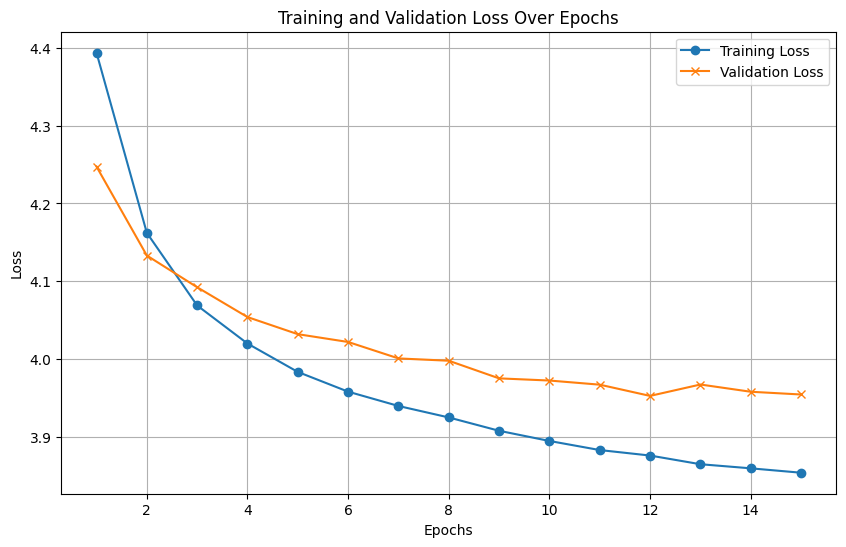

In [24]:
plot_training_losses(train_losses, val_losses)


[INFO] Evaluation on test set:
BLEU-1 Score: 0.3523
BLEU-2 Score: 0.3067
BLEU-3 Score: 0.2821
BLEU-4 Score: 0.2552
ROUGE-L Score: 0.3611


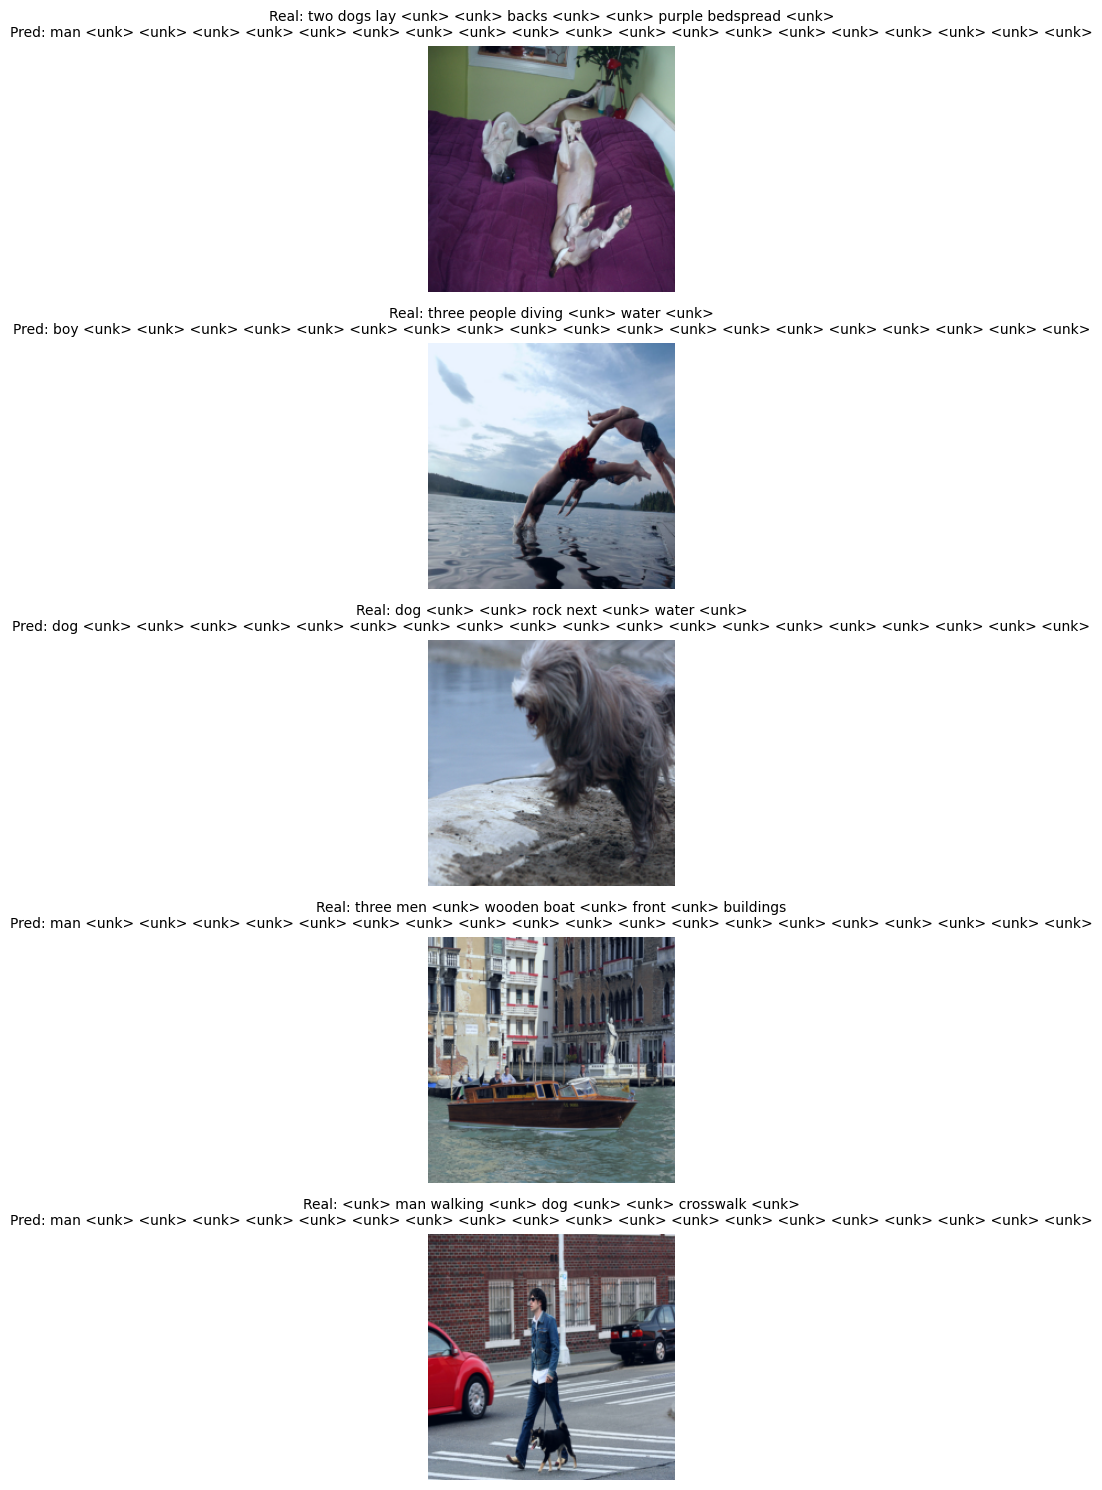

In [25]:
evaluate_model(model, test_loader, word_to_index_dictionary)

In [26]:
# visualize_results(model, test_loader, word_to_index_dictionary)